In [1]:
import gge
from gge import sensors, landcover
import json
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Create a Landsat instance and use it
cover = landcover.Sentinel2WorldCover()
cover.area = "/Users/kaaso/Documents/phd/coding/gge/Notebooks/tez2.geojson"
cover.download_data()

2025-01-11 15:40:01,833 - root - INFO - Initializing Earth Engine... (SatelliteData.py:26)
2025-01-11 15:40:05,659 - root - INFO - Earth Engine initialized. (SatelliteData.py:36)
2025-01-11 15:40:06,160 - root - INFO - download_data executed in 0.500 seconds. (exception_handler.py:10)


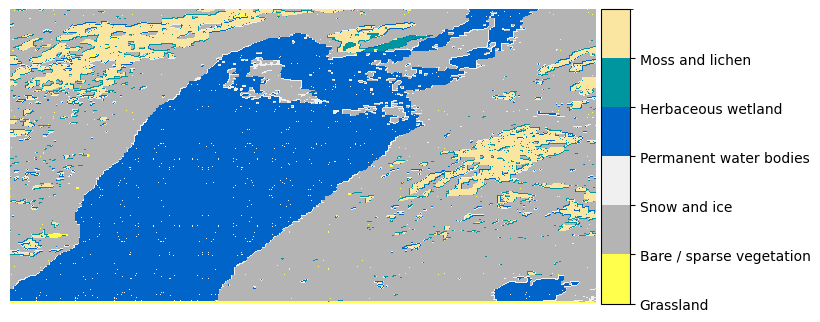

In [3]:
cover.display_world_cover()

In [6]:
# Create a Landsat instance and use it
sentinel1 = sensors.Sentinel1()

In [7]:
sentinel1.area = "/Users/kaaso/Documents/phd/coding/gge/Notebooks/tez2.geojson"
sentinel1.time_range = ('2019-01-10', '2025-01-01') 
sentinel1.download_data(bands=["hh"])


2025-01-11 15:45:10,386 - root - INFO - download_data executed in 161.339 seconds. (exception_handler.py:10)


In [9]:
im = []
times = []
orbits = []
for i in range(len(sentinel1.images_data)):
    img_tempp = np.stack((sentinel1.images_data[i]["image_bands"]["HH"],sentinel1.images_data[i]["image_bands"]["HH"]))
    im.append(img_tempp)

    times.append(sentinel1.images_data[i]["time"])
    orbits.append(sentinel1.images_data[i]["metadata"]["orbitProperties_pass"])
im = np.array(im)
orbits = np.array(orbits)


In [15]:
overall_means = np.mean(im, axis=(0,1))
overall_means.shape

(287, 571)

In [16]:
m = np.convolve(np.array(overall_means),  np.ones(5) / 5 , mode='same')
m = np.convolve(m,  np.ones(5) / 5 , mode='same')
a = np.convolve(m,  np.ones(5) / 5 , mode='same')
m = np.convolve(a,  np.ones(5) / 5 , mode='same')

m = np.convolve(m,  np.ones(5) / 5 , mode='same')
m = np.convolve(m,  np.ones(5) / 5 , mode='same')
m = np.convolve(m,  np.ones(5) / 5 , mode='same')
m = np.convolve(m,  np.ones(5) / 5 , mode='same')
m = np.convolve(m,  np.ones(5) / 5 , mode='same')
m = np.convolve(m,  np.ones(5) / 5 , mode='same')
m = np.convolve(m,  np.ones(5) / 5 , mode='same')


plt.plot(np.array(overall_means), "--", color= "black", alpha = 0.4)
plt.plot(np.array(m))


ValueError: object too deep for desired array

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime

pol = 0


# Convert time strings to day of year
days_of_year = [datetime.strptime(time, '%Y-%m-%dT%H:%M:%S').timetuple().tm_yday for time in times]

# Create a dictionary to store images by day of year
images_by_day = {}
for i, day in enumerate(days_of_year):
    if day not in images_by_day:
        images_by_day[day] = []
    images_by_day[day].append(im[i])

# Calculate the mean for each day of year
mean_images_by_day = {}
all_means = []
for day, images in images_by_day.items():
    #mean_images_by_day[day] = np.mean(images, axis=0)
    mean_images_by_day[day] = np.percentile(images,0.5, axis=0)
    all_means.append(np.mean(images, axis=0))

# Calculate the min and max values for normalization
mins = float(np.min(np.array(all_means)[:, :, :, :], axis=(0, 2, 3))[pol])
maxs = float(np.max(np.array(all_means)[:, :, :, :], axis=(0, 2, 3))[pol])

# Create a list to store the file paths of the images
images = []

# Calculate the overall means for plotting
overall_means = [np.mean(mean_images_by_day[day][pol, :, :]) for day in sorted(mean_images_by_day.keys())]

# Sort the days of the year
sorted_days = sorted(mean_images_by_day.keys())

for day in sorted_days:
    mean_image = mean_images_by_day[day]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot the image
    im_plot = ax1.imshow(mean_image[pol, :, :], cmap='gray', vmin=mins, vmax=maxs)
    ax1.axis('off')  # Hide the axes

    # Create a colorbar that matches the height of the image
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plot, cax=cax)

    # Plot the means
    ax2.plot(sorted_days, overall_means)
    ax2.axvline(x=day, color='red', linestyle='--')  # Add vertical line for the current day
    ax2.set_xlabel("Day of Year")
    ax2.set_ylabel("Mean")

    # Set x-ticks and labels to show every 20 days
    xticks = sorted_days[::20]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticks, rotation=45, ha='right')

    # Save the plot as an image file
    filename = f'image_{day}.png'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

    # Append the filename to the list
    images.append(filename)

# Create a GIF from the images
with imageio.get_writer('HH_05percentile.gif', mode='I', duration=0.5) as writer:
    for filename in images:
        image = imageio.imread(filename)
        writer.append_data(image)

# Clean up the image files
for filename in images:
    os.remove(filename)

print("GIF created successfully!")

In [ ]:

percentile_10 = np.percentile(im, 10, axis=0)
percentile_95 = np.percentile(im, 99, axis=0)
means = np.mean(im, axis = 0 )

percentile_5 = np.percentile(im, 5, axis=0)
percentile_1 = np.percentile(im,1, axis=0)
percentile_05 = np.percentile(im,0.5, axis=0)

In [ ]:
p1  = plt.hist(percentile_05[0].flatten(),bins = 50, alpha = 0.3, label = "05")
p2 = plt.hist(percentile_1[0].flatten(),bins = 50, alpha = 0.3, label = "1")
p3 = plt.hist(percentile_5[0].flatten(),bins = 50, alpha = 0.3, label = "5")
plt.legend()

In [ ]:
mask = (percentile_05[0]>-30)==0
anti_mask = (percentile_05[0]>-30)

In [ ]:
plt.imshow(mask, cmap = "gray")
plt.colorbar()

In [ ]:
mask = (percentile_05[0]>-30)==0
anti_mask = (percentile_05[0]>-30)

In [ ]:
background_img = means[0]*anti_mask

plt.imshow(background_img, cmap = "gray")
plt.colorbar()

In [ ]:
plt.imshow((percentile_05[0]*(percentile_05[0]>-30)), cmap = "gray")
plt.colorbar()

In [ ]:
plt.imshow(percentile_1[0], cmap = "gray")
plt.colorbar()

In [ ]:
plt.imshow(percentile_5[0], cmap = "gray")
plt.colorbar()

In [ ]:
plt.imshow(percentile_5[0]-percentile_95[0], cmap = "gray")


In [ ]:
plt.imshow(percentile_5[0]-percentile_95[0], cmap = "gray")
plt.colorbar()

In [ ]:
plt.imshow(percentile_95[0], cmap = "gray")
plt.colorbar()

In [ ]:
means = np.mean(im[:,1,:,:],axis = (1,2))

In [ ]:



# Generate the mask
threshold = 0.1  # Define the threshold
mask = (percentile_5 > threshold).astype(np.uint8)  # Binary mask: 1 if greater, 0 otherwise

# Visualize the mask (optional)
import matplotlib.pyplot as plt
plt.imshow(mask, cmap="gray")
plt.title("Generated Mask")
plt.axis("off")
plt.show()




In [ ]:
sentinel1.display_rgb(0,bands = ["HV"], gain = 1, gamma = 0.7)

In [ ]:
sentinel1.display_rgb(1,bands = ["HV"], gain = 1, gamma = 0.7)